In [1]:
import requests
import pandas as pd
import geopandas as gpd
import json


import dataverk as dv
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

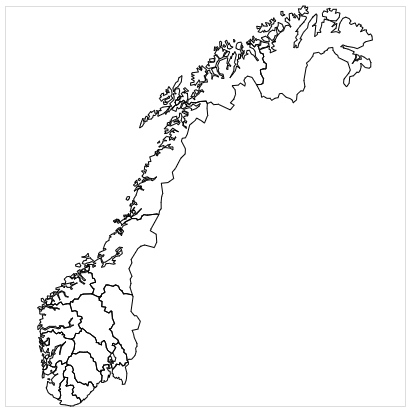

In [2]:
def download_json():
    url = "https://raw.githubusercontent.com/datasett/maps/master/norway/data/fylker_2019_s_geojson.json"
    resp = requests.get(url)
    return resp.json()

def gen_base(geojson):
    base = alt.Chart(alt.Data(values=geojson)).mark_geoshape(
        stroke='black',
        strokeWidth=1
    ).encode(
    ).properties(
        width=400,
        height=400
    )
    return base

norway_json = download_json()
base_layer = gen_base(geojson=norway_json)
base_layer

In [3]:
gdf = gpd.GeoDataFrame.from_features((norway_json))
gdf.head()

,area_fylke,centroid_fylke,fylke_navn_2019,fylke_nummer_2019,geometry
0,0.790077,"[11.165902547046743, 60.01680115972411]",AKERSHUS,02,"(POLYGON ((10.49931623545119 59.7877826916611,..."
1,1.416169,"[7.962030592135552, 58.869720988944955]",AUST-AGDER,09,"POLYGON ((6.939172524771857 59.18191548362896,..."
2,2.420100,"[9.095718794054346, 60.29402061164701]",BUSKERUD,06,"POLYGON ((9.778087417261654 59.41200210080584,..."
3,11.383869,"[25.84803378661165, 69.95301831657257]",FINNMARK,20,"(POLYGON ((29.79959688135595 69.9066839742223,..."
4,4.610300,"[11.414248455593308, 61.45436965760681]",HEDMARK,04,"POLYGON ((11.83971468575787 59.84078459855588,..."


In [4]:
conn = dv.connectors.JSONStatConnector()
df = conn.get_pandas_df('https://data.ssb.no/api/v0/no/table/10540')
df['mnd'] = df['måned'].apply(lambda x: x[4:7])
df['år'] = df['måned'].apply(lambda x: x[0:4])
fylker = gdf['fylke_navn_2019'].str.lower().tolist()
fylker

2019-08-23T17:14:21.748396: B149899 https://data.ssb.no/api/v0/no/table/10540


['akershus',
 'aust-agder',
 'buskerud',
 'finnmark',
 'hedmark',
 'hordaland',
 'møre og romsdal',
 'nordland',
 'oppland',
 'rogaland',
 'sogn og fjordane',
 'telemark',
 'troms',
 'trøndelag',
 'vest-agder',
 'vestfold',
 'østfold']

In [5]:
df = df[(df['region'].str.lower().isin(fylker)) 
        & (df['alder'] == '15-74 år' ) 
        & (df['statistikkvariabel'] == 'Registrert helt arbeidsledige' )
        & (df['mnd'] == 'M01')
       ]

df['fylke_navn_2019'] = df['region'].str.upper()

In [6]:
df.head()

,region,alder,statistikkvariabel,måned,value,mnd,år,fylke_navn_2019
588,Østfold,15-74 år,Registrert helt arbeidsledige,1999M01,3.5,M01,1999,ØSTFOLD
600,Østfold,15-74 år,Registrert helt arbeidsledige,2000M01,3.2,M01,2000,ØSTFOLD
612,Østfold,15-74 år,Registrert helt arbeidsledige,2001M01,2.9,M01,2001,ØSTFOLD
624,Østfold,15-74 år,Registrert helt arbeidsledige,2002M01,3.3,M01,2002,ØSTFOLD
636,Østfold,15-74 år,Registrert helt arbeidsledige,2003M01,4.2,M01,2003,ØSTFOLD


In [7]:
df.dtypes

region                 object
alder                  object
statistikkvariabel     object
måned                  object
value                 float64
mnd                    object
år                     object
fylke_navn_2019        object
dtype: object

In [8]:
df_p = df.pivot_table(index=['fylke_navn_2019'], values=['value'], columns='år').reset_index()

In [9]:
df_p.columns = df_p.columns.get_level_values(1)
df_p.rename(columns={ df_p.columns[0]: "fylke_navn_2019" }, inplace = True)

In [10]:
df_p.columns

Index(['fylke_navn_2019', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014'],
      dtype='object', name='år')

In [11]:
df_p

år,fylke_navn_2019,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AKERSHUS,1.5,1.5,1.4,1.9,2.7,3.1,3.0,2.5,1.7,1.2,1.8,2.6,2.5,2.3,2.3,2.6
1,AUST-AGDER,3.1,3.7,3.4,3.9,5.4,5.3,4.5,3.2,2.3,1.9,3.0,3.7,3.9,3.5,3.6,4.0
2,BUSKERUD,2.4,2.4,2.2,2.5,3.3,3.5,3.3,3.0,2.1,1.6,2.2,3.0,3.0,2.7,2.5,3.0
3,HEDMARK,3.3,2.9,2.8,3.0,3.5,3.7,3.7,3.2,2.4,1.9,2.7,3.2,3.3,2.9,2.9,3.3
4,HORDALAND,3.0,3.4,3.6,3.4,4.1,4.3,4.1,3.3,2.3,1.7,2.2,2.8,2.9,2.4,2.1,2.4
5,MØRE OG ROMSDAL,2.2,2.6,2.6,3.0,3.8,4.6,4.1,2.8,1.9,1.4,1.9,2.6,2.7,2.2,2.2,2.4
6,NORDLAND,3.7,4.0,3.9,4.1,4.6,4.9,5.0,4.3,3.1,2.4,3.1,3.2,3.3,2.9,3.1,3.2
7,OPPLAND,2.6,2.6,2.4,2.4,3.0,3.2,3.0,2.6,1.8,1.5,2.4,2.9,2.7,2.6,2.6,2.6
8,ROGALAND,2.1,3.0,3.6,3.5,4.1,4.2,3.7,2.5,1.5,1.1,1.6,2.7,2.6,1.9,1.8,2.2
9,SOGN OG FJORDANE,1.9,1.9,2.1,2.4,3.0,3.6,3.4,2.3,1.7,1.2,1.8,2.5,2.5,1.9,2.0,2.4


In [12]:
gdf = gdf.merge(df_p, on='fylke_navn_2019', how='inner')

In [13]:
gdf['centroid_lon'] = gdf['geometry'].centroid.x
gdf['centroid_lat'] = gdf['geometry'].centroid.y
gdf.head()

,area_fylke,centroid_fylke,fylke_navn_2019,fylke_nummer_2019,geometry,1999,2000,2001,2002,2003,...,2007,2008,2009,2010,2011,2012,2013,2014,centroid_lon,centroid_lat
0,0.790077,"[11.165902547046743, 60.01680115972411]",AKERSHUS,02,"(POLYGON ((10.49931623545119 59.7877826916611,...",1.5,1.5,1.4,1.9,2.7,...,1.7,1.2,1.8,2.6,2.5,2.3,2.3,2.6,11.167299,60.017100
1,1.416169,"[7.962030592135552, 58.869720988944955]",AUST-AGDER,09,"POLYGON ((6.939172524771857 59.18191548362896,...",3.1,3.7,3.4,3.9,5.4,...,2.3,1.9,3.0,3.7,3.9,3.5,3.6,4.0,7.957416,58.879414
2,2.420100,"[9.095718794054346, 60.29402061164701]",BUSKERUD,06,"POLYGON ((9.778087417261654 59.41200210080584,...",2.4,2.4,2.2,2.5,3.3,...,2.1,1.6,2.2,3.0,3.0,2.7,2.5,3.0,9.098653,60.293226
3,4.610300,"[11.414248455593308, 61.45436965760681]",HEDMARK,04,"POLYGON ((11.83971468575787 59.84078459855588,...",3.3,2.9,2.8,3.0,3.5,...,2.4,1.9,2.7,3.2,3.3,2.9,2.9,3.3,11.411927,61.454681
4,2.450177,"[6.290327336636209, 60.33278222680197]",HORDALAND,12,(POLYGON ((5.452870640241584 59.49820659843157...,3.0,3.4,3.6,3.4,4.1,...,2.3,1.7,2.2,2.8,2.9,2.4,2.1,2.4,6.320278,60.335608


In [14]:
no_json = json.loads(gdf.to_json())
no_data = alt.Data(values=no_json['features'])

In [15]:
no_data

Data({
  values: [{'id': '0', 'type': 'Feature', 'properties': {'1999': 1.5, '2000': 1.5, '2001': 1.4, '2002': 1.9, '2003': 2.7, '2004': 3.1, '2005': 3.0, '2006': 2.5, '2007': 1.7, '2008': 1.2, '2009': 1.8, '2010': 2.6, '2011': 2.5, '2012': 2.3, '2013': 2.3, '2014': 2.6, 'area_fylke': 0.7900771473057693, 'centroid_fylke': [11.165902547046743, 60.01680115972411], 'centroid_lat': 60.017100443499814, 'centroid_lon': 11.167299436956021, 'fylke_navn_2019': 'AKERSHUS', 'fylke_nummer_2019': '02'}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[10.499316235451188, 59.7877826916611], [10.342610709486541, 59.79401379322279], [10.358113262178161, 59.967989260091116], [10.489165172961085, 60.01725987147948], [10.610456248771689, 59.97660952784116], [10.628401782937937, 59.88165864925208], [10.508768137735686, 59.87809992870588], [10.499316235451188, 59.7877826916611]]], [[[10.68526365742154, 59.48628146390853], [10.582253782629701, 59.76174506673031], [10.65639529765315, 59.87184032021108

In [16]:
def gen_map(geodata, color_column, title):
    base = alt.Chart(geodata, title = title).mark_geoshape(
        stroke='black',
        strokeWidth=1
    ).encode(
    ).properties(
        width=400,
        height=400
    )
    # Add Choropleth Layer
    choro = alt.Chart(geodata).mark_geoshape(
        fill='lightgray',
        stroke='black'
    ).encode(
        alt.Color(color_column, 
                  type='quantitative', 
                  scale=alt.Scale(scheme='greenblue'),
                  title = "Arbeidsledige")
    )
    # Add Labels Layer
    labels = alt.Chart(geodata).mark_text(baseline='top'
     ).properties(
        width=400,
        height=400
     ).encode(
         longitude='properties.centroid_lon:Q',
         latitude='properties.centroid_lat:Q',
         text= color_column + ':O',
         size=alt.value(8),
         opacity=alt.value(1)
     )

    return base + choro + labels

In [17]:
ledige_2000_map = gen_map(geodata=no_data, color_column='properties.2000', title='2000')
ledige_2014_map = gen_map(geodata=no_data, color_column='properties.2014', title='2014')

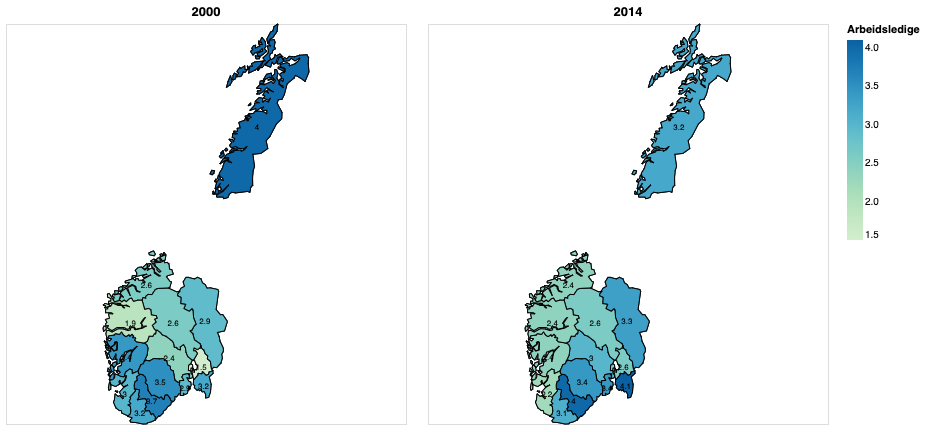

In [18]:
fig = ledige_2000_map | ledige_2014_map
fig

In [19]:
print(json.dumps(json.loads(fig.to_json()), indent=2))

{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.4.0.json",
  "config": {
    "background": "white",
    "mark": {
      "tooltip": null
    },
    "view": {
      "height": 300,
      "width": 400
    }
  },
  "data": {
    "values": [
      {
        "geometry": {
          "coordinates": [
            [
              [
                [
                  10.499316235451188,
                  59.7877826916611
                ],
                [
                  10.342610709486541,
                  59.79401379322279
                ],
                [
                  10.358113262178161,
                  59.967989260091116
                ],
                [
                  10.489165172961085,
                  60.01725987147948
                ],
                [
                  10.610456248771689,
                  59.97660952784116
                ],
                [
                  10.628401782937937,
                  59.88165864925208
                ],


In [20]:
fig.to_json()

'{\n  "$schema": "https://vega.github.io/schema/vega-lite/v3.4.0.json",\n  "config": {\n    "background": "white",\n    "mark": {\n      "tooltip": null\n    },\n    "view": {\n      "height": 300,\n      "width": 400\n    }\n  },\n  "data": {\n    "values": [\n      {\n        "geometry": {\n          "coordinates": [\n            [\n              [\n                [\n                  10.499316235451188,\n                  59.7877826916611\n                ],\n                [\n                  10.342610709486541,\n                  59.79401379322279\n                ],\n                [\n                  10.358113262178161,\n                  59.967989260091116\n                ],\n                [\n                  10.489165172961085,\n                  60.01725987147948\n                ],\n                [\n                  10.610456248771689,\n                  59.97660952784116\n                ],\n                [\n                  10.628401782937937,\n             

In [21]:
readme = """
# Altair demo: Arbeidsledige kart

"""

url = 'https://raw.githubusercontent.com/datasett/nav-examples/altair-choropleths-norway'
auth = 'paul.bencze@nav.no'

metadata = {
'store': 'gs',
'host': url,
'accessRights': 'Open',
'author': auth,
'category': 'Åpne data',
'created_by': 'paul.bencze@nav.no',
'description': 'Altair demo: Arbeidsledige kart',
'distribution': [{'format': 'datapackage','url': url}],
'format': 'datapackage',
'haspart': [],
'issued': '2019-08-14T11:14:26.802809',
'keywords': ['datasett'],
'legalbasis': ['Åpne data'],
'master': 'NAV',
'pii': 'Åpne data',
'policy': [{'legal_basis': 'Offentlighetsloven','purpose': 'Åpne data'}],
'provenance': 'Kartverket og SSB',
'publisher': 'NAV',
'purpose': ['Åpne data'],
'spatial': 'Norge',
'theme': ['Åpne data'],
'title': 'Altair demo: Arbeidsledige kart',
'type': 'datakatalog',
'url': url,
'project': 'odata', 
'user':'nav-examples',
'repo': 'https://raw.githubusercontent.com/datasett/nav-examples/altair-choropleths-norway',
'bucket': 'nav-opendata'
}

In [22]:
dp = dv.Datapackage(metadata)

In [23]:
description = '''
Arbeidsledige kart 
'''

dp.add_view(
    spec_type='vega',
    name='Arbeidsledige kart ',
    title='Arbeidsledige kart ',
    description = description,
    resources=[],
    attribution = "Kilde: NAV.",
    spec=fig.to_json()
)

In [24]:
!ls

README.md
__pycache__
altair-choropleths-norway.ipynb
altair-choropleths.ipynb
altair-demo.ipynb
altair-examples.ipynb
altair-karteksempler.ipynb
arbeidsforhold.ipynb
arbeidskraftundersøkelsen.ipynb
arbeidsmarkedet_hovedtall.ipynb
bedriftsundersøkelsen.ipynb
binder
colors.py
dashboard-simple-demo.ipynb
data
map-examples-arbeidsledige.ipynb
map-examples.ipynb
nav stillingsannonser hent fra CKAN.ipynb
nav stillingsannonser.ipynb
nav-i-tall-statistikk.ipynb
nav-i-tall.ipynb
nav-kontorer.ipynb
pandas_profiling.ipynb
process_mining_pm4py_example.ipynb
registrerte_arbeidsledige_ssb.ipynb
scripts
settings.json
sykefravær.ipynb
trygdemisbruk.ipynb
widget-test.ipynb


In [25]:
import os
with open('.env') as f:
    for line in f:
        if line.startswith('#'):
            continue
        key, value = line.strip().split('=', 1)
        os.environ[key] = value

In [26]:
client = dv.Client()
client.publish(dp)

2019-08-23T17:14:30.326364: B149899 <class 'dataverk.connectors.google_storage.GoogleStorageConnector'>: String (format: json) written to https://storage.googleapis.com/nav-opendata/f6d860ccc284e3908179f0710c9e9aba/datapackage.json
2019-08-23T17:14:31.168362: B149899 <class 'dataverk.connectors.elasticsearch.ElasticsearchConnector'>: Document f6d860ccc284e3908179f0710c9e9aba of type {'id': 'f6d860ccc284e3908179f0710c9e9aba', 'type': 'datakatalog', 'suggest': 'Altair demo: Arbeidsledige kart Altair demo: Arbeidsledige kart', 'description': 'Altair demo: Arbeidsledige kart', 'title': 'Altair demo: Arbeidsledige kart', 'format': 'datapackage', 'category': 'Åpne data', 'provenance': 'Kartverket og SSB', 'master': 'NAV', 'purpose': ['Åpne data'], 'legalbasis': ['Åpne data'], 'pii': 'Åpne data', 'issued': '2019-08-14T11:14:26.802809', 'modified': '2019-08-23T17:14:30.336467', 'modified_by': '', 'created': '2019-08-23T17:14:30.336472', 'updated': '2019-08-23', 'created_by': 'paul.bencze@nav.n